In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path

from preprocessing import preprocess_ecmwf, preprocess_target, preprocess_raw_forecasts
from cnn_training import generate_climprob_inputs, ModelRegistry, construct_climdev_cnn, DEFAULT_FIT, DEFAULT_COMPILE, DEFAULT_CONSTRUCT
from verification import l1yocv_climatology, brier_skill_score, reliability_diagram

## Description of forecast data
In "/data/volume_2/subseasonal/ecmwf/" we have stored extended range forecast data from the ecmwf center. This is a sub-set of the S2S database, a subset that was published as part of the S2S-AI competition https://s2s-ai-challenge.github.io/ 

The data is separated in 20 years of hindcasts (a.k.a. re-forecasts) with 11 members (2000-2019), and one year of operational forecasts with 51 members (2020).

Our target is 4-week accumulated rainfall in the Horn of Africa, forecast at a sub-seasonal lead time of 2 weeks. This means we evaluate the predictions over week 3+4+5+6. We have selected those weeks, and pre-aggregated all data for you, script: 'aggregation.py', data directory: "/data/volume_2/subseasonal/ecmwf/aggregated/". This gridded data is global, at a resolution of 1.5x1.5 degrees. Multiple variables are present:

In [2]:
list(Path('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/').glob('*.nc'))

[PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-gh-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tcw-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-t2m-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm20-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sm100-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-sst-week3456.nc'),
 PosixPath('/data/volume_2/subseasonal/ecmwf/aggregated/forecast/ecmwf-forecast-tp-week3456.nc')]

Among these are:
* 'total precipitation' (tp) of course
* but also 'total column water' (tcw)
* 'geopotential at 500 hPa' (gh)
* 'two-meter-temperature' (t2m)
* 'soil moisture 0-20 cm' (sm20)
* 'soil moisture 0-100 cm' (sm100)
* 'sea surface temperature' (sst). 

Further details in the attributes and here: https://confluence.ecmwf.int/display/S2S/Parameters  

A pre-aggregated (still gridded) target variable from CHRIPS is available in two spatial resolutions:

In [5]:
list(Path('/data/volume_2/observational/preprocessed/').glob('*4week*.nc'))

[PosixPath('/data/volume_2/observational/preprocessed/chirps_tp_2000-2020_4weekly_0.25deg_africa.nc')]

## Pre-processing data for the CNN
The current application takes in gridded patches centered over the Horn of Africa and predicts a scaler or categorical variable. The stack of patches can comprise multiple forecasted variables from ecmwf (like precipitation and temperature), all of the ensemble members, or summery statistics like the ensemble mean.
These multiple variable cannot be fed directly, but need to be standardized and put on the same scale. This is what pre-processing does. Several choices need to be made (and can be experimented with):
* removing the seasonal cycle?
* which variables to include?
* ensemble mean or members, or ...?
* standardize per grid point over time (i.e. remove climatological gradients) or standardize patch over space, per moment in time?

Also for the target choices need to be made:
* Over which masked spatial region do I average?
* What quantiles do I use for categorizing it?

In [2]:
scratchdir = Path('/scratch/cvanstraat')
experiment_name = 'trial5_ensmean_something'
ensmean = True
varlist = ['tcw']
season = None
patchsize = 40

In [3]:
# Construction of Patched inputs
training_inputs = {key:[] for key in varlist}  # These will be hindcasts
testing_inputs = {key:[] for key in varlist}  # These will be forecasts (though probably more testing data will be generated through crossvalidation of hindcasts)
for var in varlist:
    if var == 'tp': # No seasonal anomalies
        hindcast, forecast = preprocess_ecmwf(season = season, var = var, rm_season = False, ensmean = ensmean, standardize_space = False, standardize_time = True, patchsize=patchsize) # No seasonal removal for rainfall? Perhaps rainfall should be min-max scaled, such that zero is really zero?
    else:
        hindcast, forecast = preprocess_ecmwf(season = season, var = var, rm_season = True, ensmean = ensmean, standardize_space = False, standardize_time = True, patchsize=patchsize)
    training_inputs[var] = hindcast.expand_dims({'variable':[var]})
    testing_inputs[var] = forecast.expand_dims({'variable':[var]})

training_inputs = xr.concat(training_inputs.values(), dim = 'variable') # This already stacks the arrays into nchannels = nvariables 
testing_inputs = xr.concat(testing_inputs.values(), dim = 'variable')

# If not ensmean then extra stacking of channels, as multiple members available per variable
if not ensmean:
    nmembers = len(training_inputs.coords['realization'])
    training_inputs = training_inputs.stack({'channels':['realization','variable']})
    testing_inputs = testing_inputs.sel(realization = np.random.choice(testing_inputs.realization.values, size = nmembers, replace = False)) # Testing now needs to be matched in training, so downsampling the members to 11 (always select control?)
    testing_inputs = testing_inputs.stack({'channels':['realization','variable']})
else:
    training_inputs = training_inputs.rename({'variable':'channels'})
    testing_inputs = testing_inputs.rename({'variable':'channels'})
    
training_inputs = training_inputs.fillna(-999)
testing_inputs = testing_inputs.fillna(-999)

# processing target (one-hot encoded)
quantile_edges = [0.33]
target_h, target_f, chirps_edges = preprocess_target(return_edges = True) # Edges indexed by day-of-the-year
chirps_edges = chirps_edges.to_pandas().groupby(pd.date_range('2004-01-01','2004-12-31').month).mean() # index edges by month
# Extracting benchmark forecasts for the categorized spatial average (no input to the CNN, but to be used as 'raw' benchmark) 
hindcast_benchmark, forecast_benchmark, ecmwf_edges = preprocess_raw_forecasts(quantile_edges = quantile_edges, return_edges = True)
ecmwf_edges = ecmwf_edges.to_pandas()

attempt patch selection lat:slice(21.5, -18.5, None), lon:slice(26.0, 66.0, None)
attempt patch selection lat:slice(21.5, -18.5, None), lon:slice(26.0, 66.0, None)
computing seasonality of individual members, members treated as extra samples for the climate
seasonal expectation is presupplied
standardization is temporal
computing standard scaler on (1060, 729), members as samples = False
standardization is temporal
using pre-trained standard scaler on (53, 729), members as samples = False
season not defined so defaulted to full year


2022-09-08 15:01:47.885218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:01:47.946036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:01:47.946336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:01:47.950492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
"""
Writing the choices of the experiment to disk (under experiment_name)
"""
# Re-ordering and writing inputs to disk (only array, no coordinates, so directly readable with numpy (and tensorflow)
# (nsamples,nlat,nlon,nchannels)
np.save(file = scratchdir / f'{experiment_name}.training_inputs.npy', arr = training_inputs.transpose('valid_time','latitude','longitude','channels').values)
np.save(file = scratchdir / f'{experiment_name}.testing_inputs.npy', arr = testing_inputs.transpose('valid_time','latitude','longitude','channels').values)

# writing targets to disk (nsamples, nclasses)
np.save(file = scratchdir / f'{experiment_name}.training_terciles.npy', arr = target_h.values)
np.save(file = scratchdir / f'{experiment_name}.testing_terciles.npy', arr = target_f.values)

# Writing benchmarks to disk (nsamples, nclasses), not as numpy but as pandas because no feeding into neural network
hindcast_benchmark.to_pandas().to_hdf(scratchdir / f'{experiment_name}.training_benchmark.h5', key = 'benchmark', mode = 'w')
forecast_benchmark.to_pandas().to_hdf(scratchdir / f'{experiment_name}.testing_benchmark.h5', key = 'benchmark', mode = 'w')

# Some extra time information
target_h.valid_time.to_pandas().to_hdf(scratchdir / f'{experiment_name}.training_timestamps.h5', key = 'timestamps', mode = 'w')
target_f.valid_time.to_pandas().to_hdf(scratchdir / f'{experiment_name}.testing_timestamps.h5', key = 'timestamps', mode = 'w')

<AxesSubplot:>

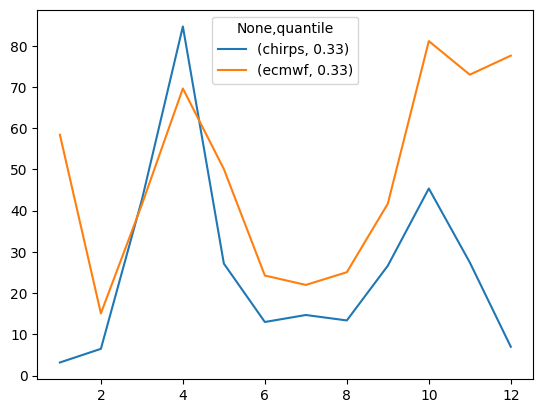

In [5]:
# Important that terciles computed on chrips are not projected onto ecmwf.
pd.concat([chirps_edges * 28,ecmwf_edges], axis = 1, keys = ['chirps','ecmwf']).plot()

## CNN training
reading the input from disk again. In the pre-processing we enforced a distinction between hindcasts and forecasts, for instance by estimating the standard deviation and mean for standardization on the hindcasts only. This to prevent data-leakage between hindcasts and forecasts, were we to decide that the single year of forecasts should be used as a separate test set. However, a single year (or a single rainy season) is not enough for reliable scores. So to compute scores on the entire dataset we put everything in a cross-validation framework.

This crossvalidation is a nested crossvalidation. First a leave-one-year-out for testing, and within that a leave-three-year-out for validation (the three years are arbitratily chosen as length for the validation set. We want the scores in validation to be relatively stable, because it is input to the early stopping algorithm).

In [6]:
# Preparation of input and target data
train_inputs = np.load(scratchdir / f'{experiment_name}.training_inputs.npy') # (nsamples,nlat,nlon,nchannels), if ensmean then channels is just the number of variables, nlat & nlon depend on patch size
train_target = np.load(scratchdir / f'{experiment_name}.training_terciles.npy') # Spatial average 4-week rainfall classified into terciles, one hot encoded (low, mid, high)
train_timestamps = pd.read_hdf(scratchdir / f'{experiment_name}.training_timestamps.h5')

test_inputs = np.load(scratchdir / f'{experiment_name}.testing_inputs.npy') # these are the forecasts that have been kept separate
test_target = np.load(scratchdir / f'{experiment_name}.testing_terciles.npy')
test_timestamps = pd.read_hdf(scratchdir / f'{experiment_name}.testing_timestamps.h5')

full_inputs = np.concatenate([train_inputs, test_inputs], axis = 0) # Stacking along valid_time/sample dimension
full_target = np.concatenate([train_target, test_target], axis = 0) # Stacking along valid_time/sample dimension
full_timestamps = pd.concat([train_timestamps, test_timestamps])

# Now we want to prepare input to the second branch of the neural network (the base probabilities for each of the classes)
n_classes = full_target.shape[-1]
full_clim_logprobs = generate_climprob_inputs(full_inputs, climprobs = full_target.mean(axis = 0)) # 3 classes are assumed to be equiprobable terciles

In [7]:
# Now is the moment to choose your hyperparameters
# We supply them as kwargs to the structure that will initialize and contain all models
registry = ModelRegistry(xdata = [full_inputs, full_clim_logprobs],
        ydata = full_target,
        timestamps = full_timestamps.index,
        compile_kwargs = DEFAULT_COMPILE, construct_kwargs = DEFAULT_CONSTRUCT, fit_kwargs = DEFAULT_FIT)

In [21]:
# Leave one year out cross-validation (for testing)
# This leaves 21 years remaining, although there are not really 22 full years (2021 has only three samples)
# nested within this, a leave-three-years-out crossvalidation (meaning 7 folds)
years = full_timestamps.index.year.unique()
for test_year in years:
    remaining_years = years.drop(test_year).sort_values() # sort to make sure that the next leaving out is blockwise
    for validation_years in np.split(remaining_years, np.arange(3, len(remaining_years),3)):
        training_years = years.drop(test_year).drop(validation_years)
        print('test', test_year)
        print('validation', validation_years)
        print('training', training_years)
        test_indices = np.where(full_timestamps.index.year == test_year)[0] # From boolean to numeric index
        val_indices = np.where(full_timestamps.index.year.map(lambda y: y in validation_years))[0]
        train_indices = np.where(full_timestamps.index.year.map(lambda y: y in training_years))[0]
        modelindex = registry.initialize_untrained_model(train_indices = train_indices, val_indices = val_indices, test_indices = test_indices)
        print(modelindex)
        registry.train_model(modelindex = modelindex)

test 2000
validation Int64Index([2001, 2002, 2003], dtype='int64', name='valid_time')
training Int64Index([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
            2015, 2016, 2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='valid_time')
0
Epoch 1/10


ValueError: in user code:

    File "/home/cvanstraat/VENV/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/cvanstraat/VENV/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cvanstraat/VENV/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/cvanstraat/VENV/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/home/cvanstraat/VENV/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/cvanstraat/VENV/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 1 of layer "model" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 2)


In [28]:
# After training we can inspect scores as a function of epoch, and the informative difference between training loss and validation loss.
curves = registry.build_curves()

<AxesSubplot:xlabel='epoch'>

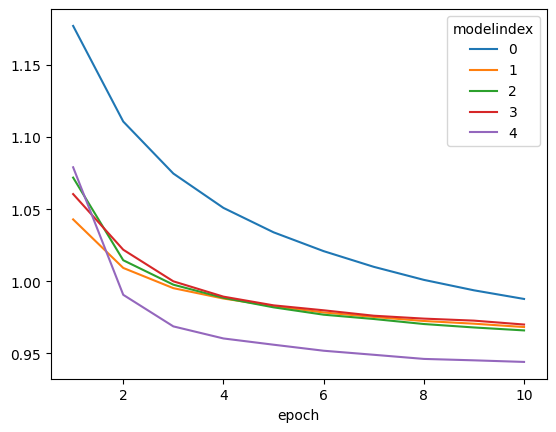

In [42]:
curves.loc[slice(4),'loss'].unstack(0).plot()

## Verification
verification on the test set. Comparison to unprocessed ecmwf forecasts, and to a simple climatological benchmark. 

In [8]:
# Load the benchmark forecasts (spatially averaged, classified using terciles estimated on hindcasts).
full_benchmark = pd.concat([pd.read_hdf(scratchdir / f'{experiment_name}.training_benchmark.h5'),
                            pd.read_hdf(scratchdir / f'{experiment_name}.testing_benchmark.h5')], axis = 0)

In [10]:
full_benchmark.mean(0)

classes
0    0.327641
1    0.672359
dtype: float64

In [11]:
full_target.mean(0)

array([0.67026055, 0.32973945], dtype=float32)

In [23]:
# Extract predictions by the CNN's, and create pandas from observations
cnnpreds = registry.make_predictions('test') # This contains predictions by all models (also untrained ones if you have not trained all that you've added)
verifying_obs = pd.DataFrame(full_target, index = full_timestamps.index, columns = full_benchmark.columns) # This is the fullset, one-hot-encoded
#verifying_obs =  # Samples are in multiple validation sets so reindex to make obs align with preds

In [12]:
# Note length difference in cnnpreds as nested cv causes each test year to occur 7 times.
print(len(verifying_obs),len(cnnpreds))

1113 7791


raw BSS:  0.07039831913471006


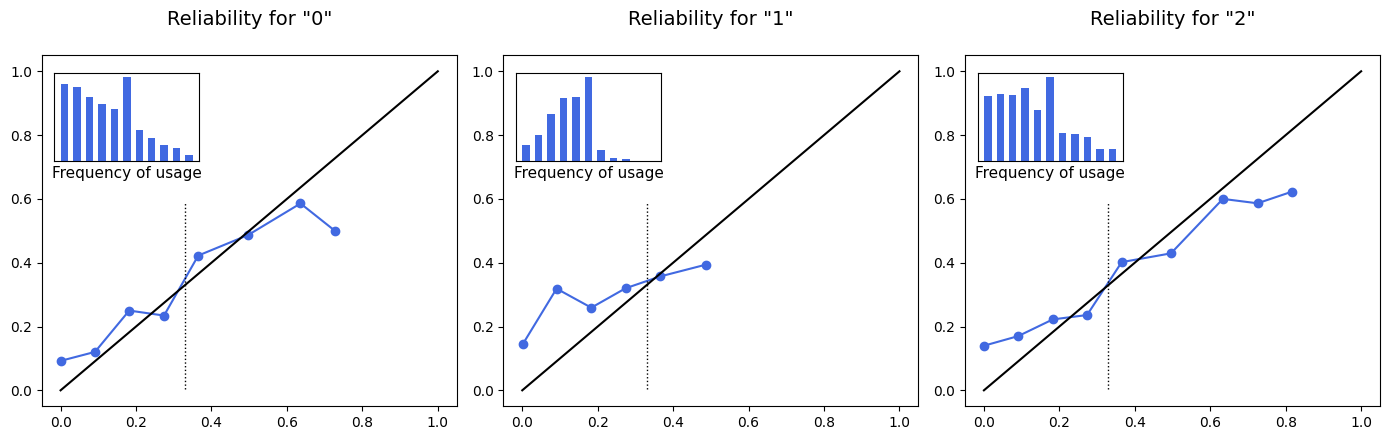

In [24]:
# raw forecasts relative to simple (leave 1 year out) climatology
clim_benchmark = l1yocv_climatology(verifying_obs)
print('raw BSS: ', brier_skill_score(y = verifying_obs, x = full_benchmark, x0 = clim_benchmark))
fig, ax = reliability_diagram(y = verifying_obs, x = full_benchmark)
plt.show()

cnn BSS:  0.047766886768054184


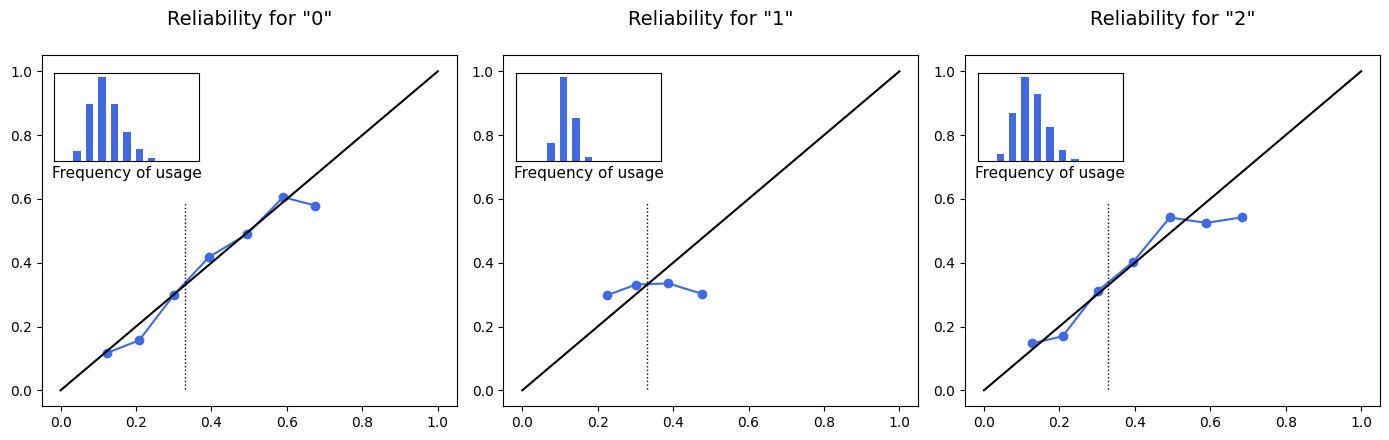

In [25]:
# Cnn forecasts relative to simple climatology
lengthened_obs = verifying_obs.reindex(cnnpreds.index)
clim_benchmark = l1yocv_climatology(lengthened_obs)
print('cnn BSS: ', brier_skill_score(y = lengthened_obs, x = cnnpreds, x0 = clim_benchmark))
fig, ax = reliability_diagram(y = lengthened_obs, x = cnnpreds)
plt.show()